# 0-π oscillations in altermagnetic Josephson junctions

## Common imports


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from bodge import *

## Lattice construction
These functions take lattice coordinates $i, j ∈ \mathbb{N}^3$ as inputs, and for a given junction type (0º or 45º interfaces) determines whether a region is superconducting, normal metallic, or altermagnetic. Note that these functions depend on some global variables like `DIAG` and `L_SC`, which are used to alter the properties of the junctions investigated below. These variables are declared here but updated below.

In [4]:
# Whether the system has a diagonal interface.
DIAG = False

# Dimensions of the cubic lattice.
L_X = 0
L_Y = 0
L_Z = 0

# Superconductor length.
L_SC = 0 

# Normal-metal spacer length.
L_NM = 0

# Interlayer length. This can be an altermagnet.
L_IL = 0

This function calculates an "equivalent x-coordinate" for junctions with diagonal interfaces, defined as the x-coordinate at the center along the y-axis.

In [5]:
def diax(i):
    return i[0] + (i[1] - L_Y//2) * DIAG

These functions check whether a coordinate is superconducting, normal metallic, or altermagnetic.

In [4]:
def SC1(i):
    return diax(i) < L_SC
    
def SC2(i):
    return diax(i) >= L_X - L_SC

def NM1(i):
    return diax(i) < L_SC + L_NM and not SC1(i)

def NM2(i):
    return diax(i) >= L_X - L_SC - L_NM and not SC2(i)

def IL(i):
    return not SC1(i) and not SC2(i) and not NM1(i) and not NM2(i)

These functions let us calculate the y-integrated current in the middle of the first normal-metal layer, which we will use as a measure for the supercurrent. We calculate the current at $T = 0.01t$ for now.

In [5]:
def probe(i):
    return diax(i) == L_SC + L_NM//2

def current(system, N=600):
    F = FermiMatrix(system, N)(0.01)
    Jx = F.current_elec(axis=0)
    Jy = F.current_elec(axis=1)

    J = 0.0
    for i in lattice.sites():
        if probe(i):
            if DIAG:
                # Current in 45º direction.
                J += (Jx[i] + Jy[i])/np.sqrt(2)
            else:
                # Current in 0º direction.
                J += Jx[i]

    return J

We can also define a function for visualizing the lattices, to reduce the chance of errors. The evaluation point for currents is plotted in red.

In [6]:
def show():
    lattice = CubicLattice((L_X, L_Y, L_Z))

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()

    for i in lattice.sites():
        if SC1(i) or SC2(i):
            ax.scatter(x=i[0], y=i[1], color='#ff7f00')
        if NM1(i) or NM2(i):
            ax.scatter(x=i[0], y=i[1], color='k')
        if IL(i):
            ax.scatter(x=i[0], y=i[1], color='#984ea3')
        if probe(i):
            ax.scatter(x=i[0], y=i[1], color='#ff0000')

    plt.show()

Let's test that these work as expected by plotting one diagonal and one non-diagonal lattice.

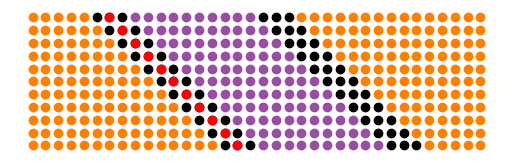

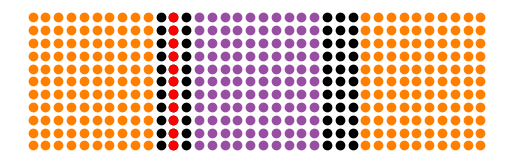

In [7]:
L_SC = 10 
L_NM = 3
L_IL = 10

L_X = 2 * L_SC + 2 * L_NM + L_IL
L_Y = 11
L_Z = 1

DIAG = True

show()

DIAG = False

show()

## Normal-metal baseline


For comparison to the altermagnetic case, let's do a quick run on normal metals (which have no 0-π oscillations). Based on separate benchmarks of the Chebyshev code, we should use 600 polynomials at least for explorative current calculations and perhaps 2000 for final ones.

First, let's define the tight-binding parameters:

In [8]:
t = 1.0
μ = -t/2
Δ0 = -t
δφ = π/2

  0%|          | 0/15 [00:00<?, ?it/s]

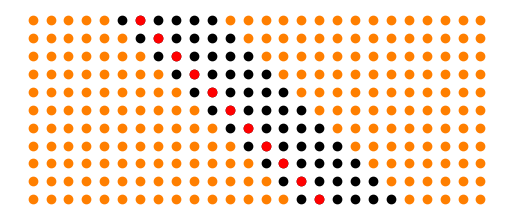

  7%|▋         | 1/15 [00:03<00:55,  3.98s/it]

	J/t = 4.202698778997574


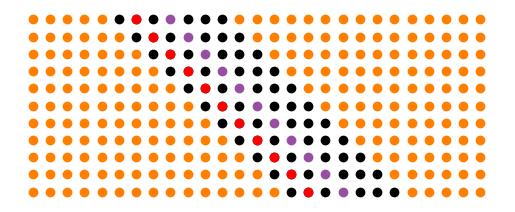

 13%|█▎        | 2/15 [00:08<00:53,  4.15s/it]

	J/t = 3.4548206594483726


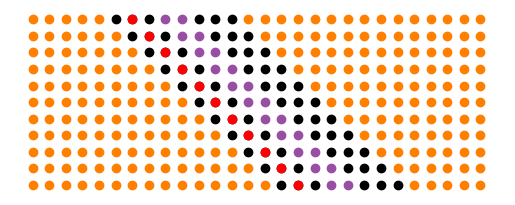

 20%|██        | 3/15 [00:12<00:52,  4.37s/it]

	J/t = 3.2600282608025495


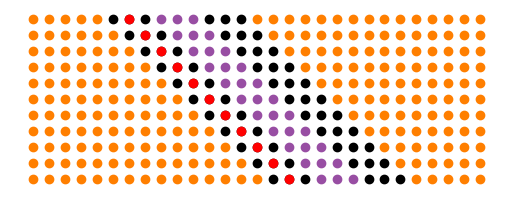

 27%|██▋       | 4/15 [00:17<00:50,  4.55s/it]

	J/t = 2.6936286599058117


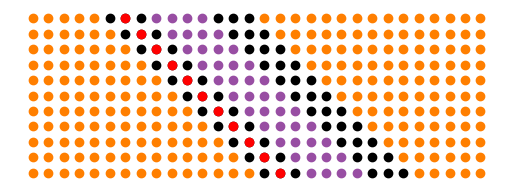

 33%|███▎      | 5/15 [00:22<00:48,  4.81s/it]

	J/t = 2.5708390739569276


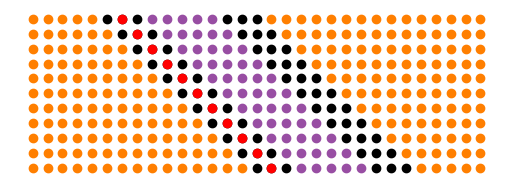

 40%|████      | 6/15 [00:28<00:45,  5.01s/it]

	J/t = 2.177927350099716


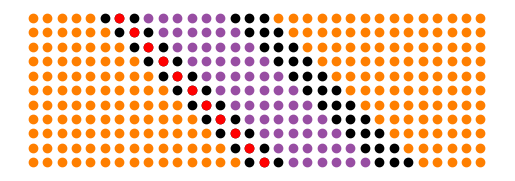

 47%|████▋     | 7/15 [00:34<00:42,  5.26s/it]

	J/t = 2.06227663526919


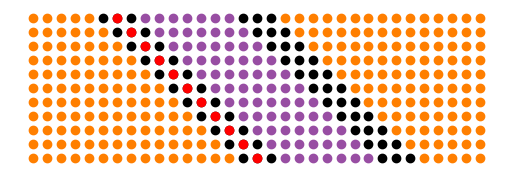

 53%|█████▎    | 8/15 [00:40<00:38,  5.53s/it]

	J/t = 1.7920600483358151


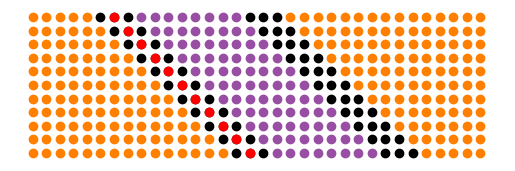

 60%|██████    | 9/15 [00:46<00:34,  5.81s/it]

	J/t = 1.6751578460100163


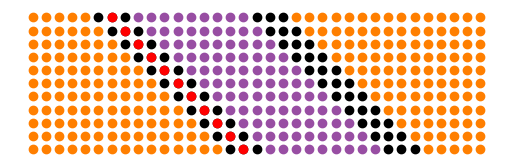

 67%|██████▋   | 10/15 [00:53<00:30,  6.11s/it]

	J/t = 1.5002574582728043


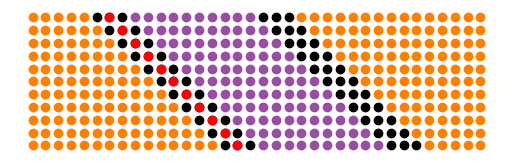

 73%|███████▎  | 11/15 [01:00<00:25,  6.45s/it]

	J/t = 1.3820269615436889


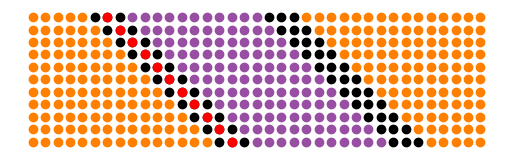

 80%|████████  | 12/15 [01:08<00:20,  6.77s/it]

	J/t = 1.2772961537011183


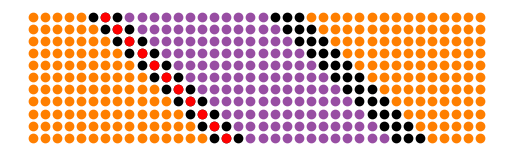

 80%|████████  | 12/15 [01:13<00:18,  6.10s/it]


KeyboardInterrupt: 

In [9]:
LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(15):
        L_Y = 11
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                H[i, i] = -μ * σ0
                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)
            for i, j in lattice.bonds():
                H[i, j] = -t * σ0
        
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

This shows a qualitatively similar behavior for S/N/S junctions with the two different types of interfaces, although the curves quantitatively differ by perhaps 10% or so.

## Ferromagnetic baseline

Let's now try to use a ferromagnetic interlayer and repeat the experiment above. The point is to show that we can get 0-π oscillations for both types of interfaces, as a comparison for the altermagnets.

In [10]:
m = 3 * t / 2

  0%|          | 0/19 [00:00<?, ?it/s]

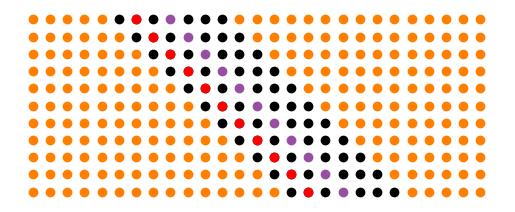

  5%|▌         | 1/19 [00:04<01:19,  4.40s/it]

	J/t = 2.854504664059803


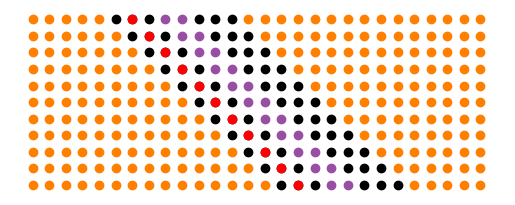

 11%|█         | 2/19 [00:08<01:16,  4.51s/it]

	J/t = -0.6857515459102708


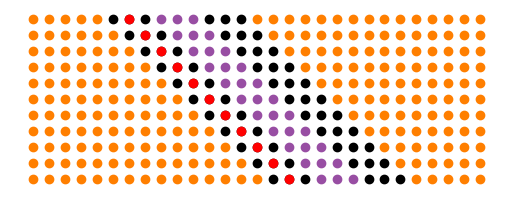

 16%|█▌        | 3/19 [00:13<01:14,  4.67s/it]

	J/t = -2.3047684930509162


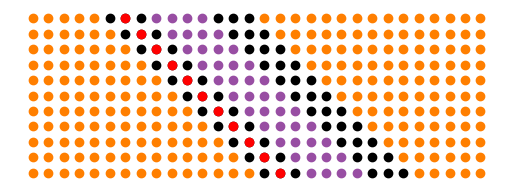

 21%|██        | 4/19 [00:19<01:13,  4.90s/it]

	J/t = -1.5317545252530458


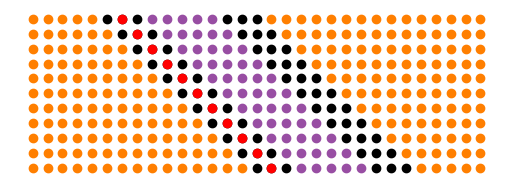

 26%|██▋       | 5/19 [00:24<01:11,  5.11s/it]

	J/t = -0.7245022120319213


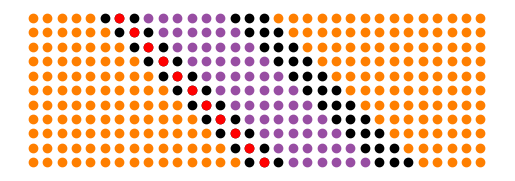

 32%|███▏      | 6/19 [00:30<01:09,  5.37s/it]

	J/t = 0.4208673088191589


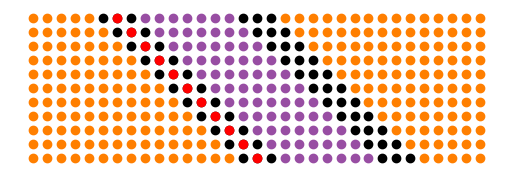

 37%|███▋      | 7/19 [00:36<01:07,  5.63s/it]

	J/t = 1.035010467117132


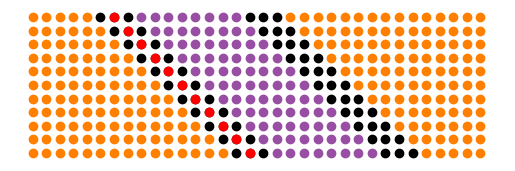

 42%|████▏     | 8/19 [00:43<01:04,  5.89s/it]

	J/t = 0.7972237938578415


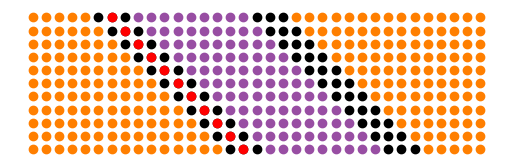

 47%|████▋     | 9/19 [00:49<01:01,  6.19s/it]

	J/t = 0.2901086536507275


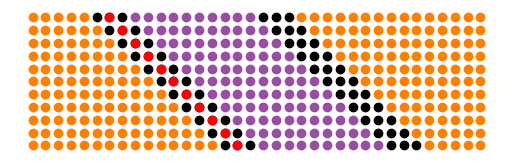

 53%|█████▎    | 10/19 [00:57<00:58,  6.48s/it]

	J/t = -0.3233953543476659


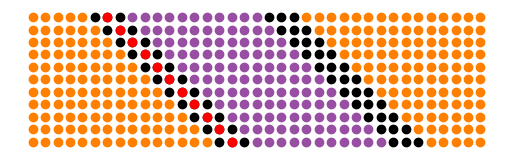

 58%|█████▊    | 11/19 [01:04<00:54,  6.80s/it]

	J/t = -0.5814817939252293


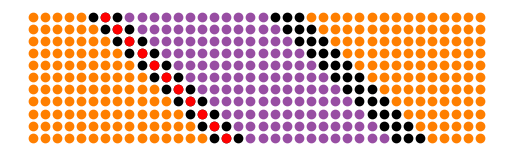

 58%|█████▊    | 11/19 [01:07<00:49,  6.16s/it]


KeyboardInterrupt: 

In [11]:
LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(1, 20):
        L_Y = 11
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                if IL(i):
                    H[i, i] = -μ * σ0 - m * σ3
                else:
                    H[i, i] = -μ * σ0

                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)
            for i, j in lattice.bonds():
                H[i, j] = -t * σ0
        
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

Clearly, the interface type changes the period drastically, but 0-π oscillations occurs for both.

## Altermagnetic test for δφ = π/2


  0%|          | 0/19 [00:00<?, ?it/s]

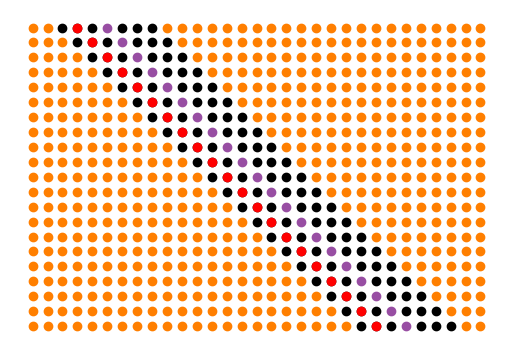

  5%|▌         | 1/19 [00:17<05:20, 17.82s/it]

	J/t = 7.281984602396355


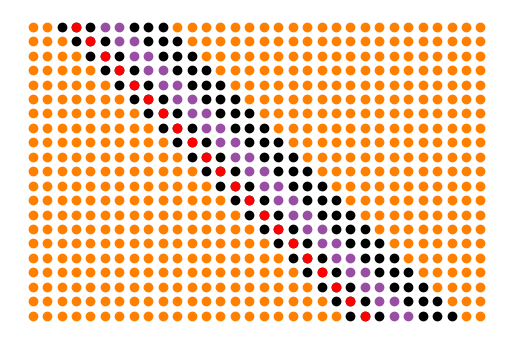

 11%|█         | 2/19 [00:36<05:15, 18.58s/it]

	J/t = 2.658211179507482


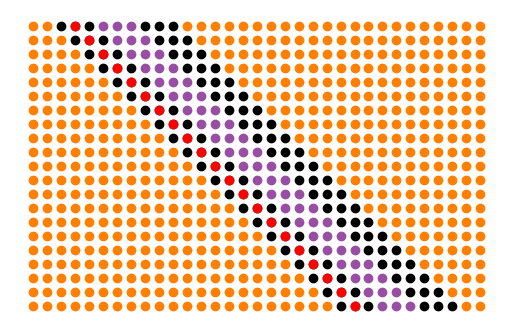

 16%|█▌        | 3/19 [00:56<05:08, 19.26s/it]

	J/t = -1.8232662902564316


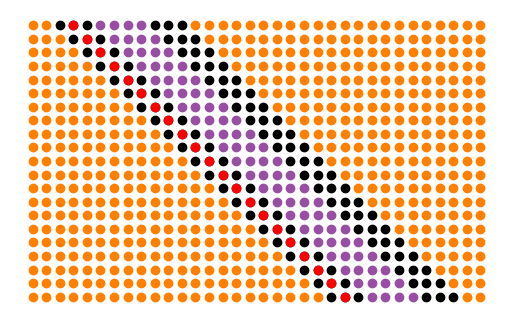

 16%|█▌        | 3/19 [01:01<05:27, 20.45s/it]


KeyboardInterrupt: 

In [13]:
m = 1.5 * t
L_Y = 21
L_SC = 12

LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(1, 20):
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                H[i, i] = -μ * σ0

                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

            for i, j in lattice.bonds(axis=0):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 - m * σ3
                else:
                    H[i, j] = -t * σ0

            for i, j in lattice.bonds(axis=1):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 + m * σ3
                else:
                    H[i, j] = -t * σ0
    
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

**Conclusion:** Diagonal interface alone is insufficient to prevent 0-π oscillations inside of altermagnets. It appears we need to make the whole junction diagonal to prevent them from appearing.

## Lattice construction revised
Let's now revise the lattice construction to make perfectly diagonal junctions. First, we define functions `x` and `y` to generate the junction coordinates that correspond to a provided lattice coordinate `i`.

In [6]:

def x(i):
    if not DIAG:
        return i[0]
    else:
        return (i[0] + (L_X - i[1]))//2

def y(i):
    if not DIAG:
        return i[1]
    else:
        return (i[0] - (L_X - i[1]))//2


We also need a safeguard function to check if a coordinate is in the junction.

In [7]:
def inside(i):
    return x(i) >= 0 and x(i) < L_X and y(i) >= 0 and y(i) < L_Y

Now, we revise the functions used to define the junction we considered before.

In [8]:
def SC1(i):
    return inside(i) and x(i) < L_SC
    
def SC2(i):
    return inside(i) and x(i) >= L_X - L_SC

def NM1(i):
    return inside(i) and x(i) < L_SC + L_NM and not SC1(i)

def NM2(i):
    return inside(i) and x(i) >= L_X - L_SC - L_NM and not SC2(i)

def IL(i):
    return inside(i) and not SC1(i) and not SC2(i) and not NM1(i) and not NM2(i)

In [9]:
def probe(i):
    return inside(i) and x(i) == L_SC + L_NM//2

In [10]:
def create():
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()
    marker="."

    if DIAG:
        sidelength = L_X + L_Y
        lattice = CubicLattice((sidelength, sidelength, 1))
    else:
        lattice = CubicLattice((L_X, L_Y, 1))

    NS = 0
    NP = 0
    for i in lattice.sites():
        if probe(i):
            ax.scatter(x=i[0], y=i[1], color='#ff0000', marker=marker)
            NP += 1
        elif SC1(i) or SC2(i):
            NS += 1
            ax.scatter(x=i[0], y=i[1], color='#ff7f00', marker=marker)
        elif NM1(i) or NM2(i):
            ax.scatter(x=i[0], y=i[1], color='k', marker=marker)
        elif IL(i):
            ax.scatter(x=i[0], y=i[1], color='#984ea3', marker=marker)
        else:
            ax.scatter(x=i[0], y=i[1], color='#eeeeee', marker=marker)
    print(NS, NP)

    plt.show()

    return lattice

484 22


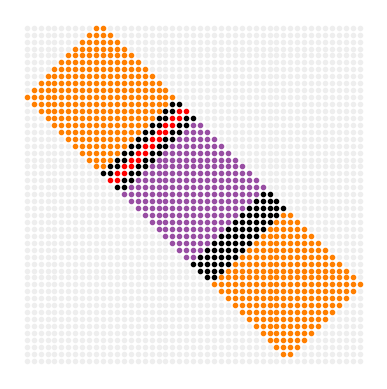

448 16


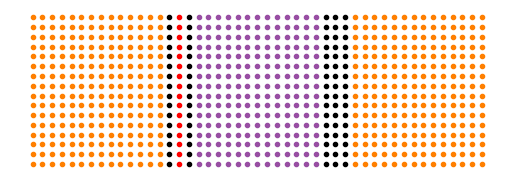

In [11]:
L_SC = 11 
L_NM = 3
L_IL = 10

L_X = 2 * L_SC + 2 * L_NM + L_IL
L_Y = 11
L_Z = 1

DIAG = True

lattice = create()

DIAG = False

L_SC = int(1.33 * L_SC)
L_NM = int(1.33 * L_NM)
L_IL = int(1.33 * L_IL)
L_Y = int(1.5 * L_Y)

L_X = 2 * L_SC + 2 * L_NM + L_IL

lattice = create()

## New altermagnets

In [12]:
def current(system, N=600):
    F = FermiMatrix(system, N)(0.01)
    Jx = F.current_elec(axis=0)
    Jy = F.current_elec(axis=1)

    J = 0.0
    for i in lattice.sites():
        if inside(i):
            if probe(i):
                if DIAG:
                    # Current in 45º direction.
                    J += (Jx[i] - Jy[i])/np.sqrt(2)
                else:
                    # Current in 0º direction.
                    J += Jx[i]

    return J

  0%|          | 0/7 [00:00<?, ?it/s]

484 22


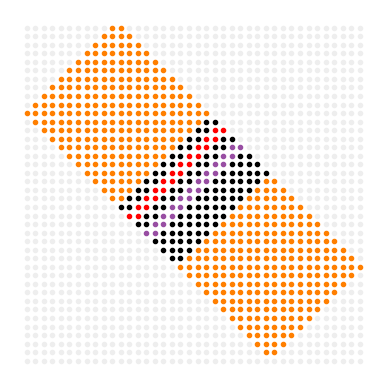

 14%|█▍        | 1/7 [00:35<03:32, 35.50s/it]

	J/t = 4.293736889053665
484 22


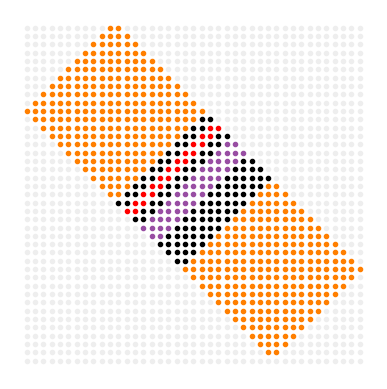

 29%|██▊       | 2/7 [01:13<03:05, 37.11s/it]

	J/t = 0.5045303134707452
484 22


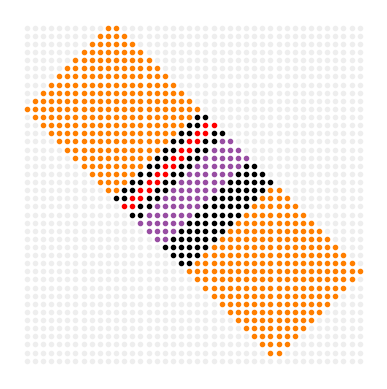

 43%|████▎     | 3/7 [01:54<02:35, 38.82s/it]

	J/t = 0.1121178763991164
484 22


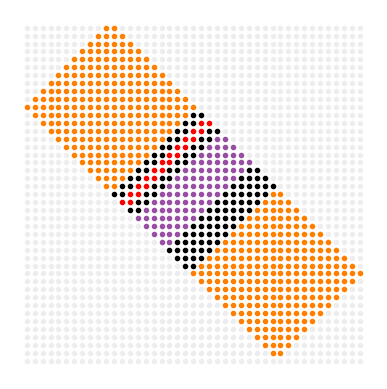

 57%|█████▋    | 4/7 [02:37<02:01, 40.59s/it]

	J/t = 0.007940221734722055
484 22


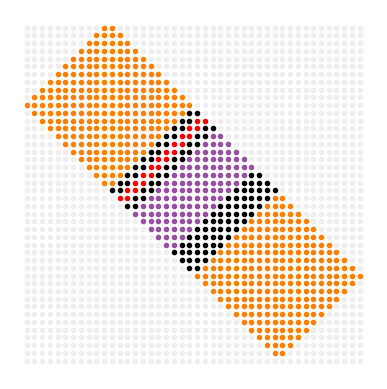

 71%|███████▏  | 5/7 [03:24<01:25, 42.60s/it]

	J/t = 0.03677255299882593
484 22


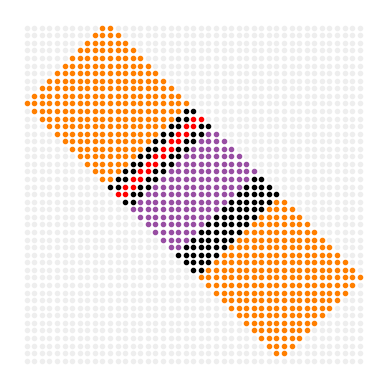

 86%|████████▌ | 6/7 [04:12<00:44, 44.72s/it]

	J/t = -0.014610087608850518
484 22


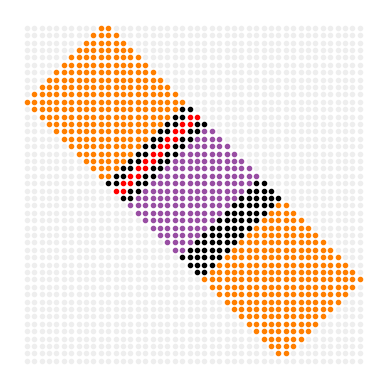

100%|██████████| 7/7 [05:04<00:00, 43.57s/it]

	J/t = -0.008582809926613236


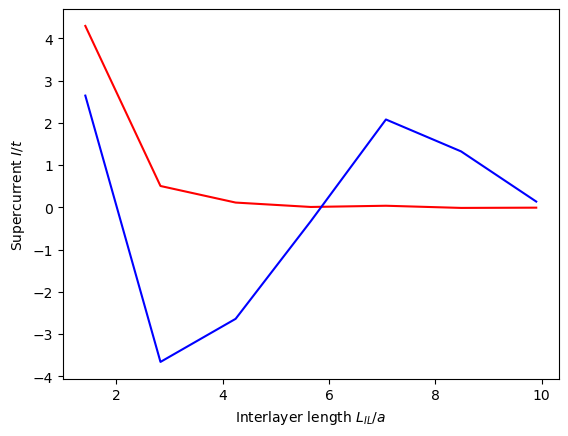

In [18]:
t = 1.0
Δ0 = -t
μ = -t/2
m = 0.5 * t
δφ = π/2

L_SC = 11 
L_NM = 3
L_IL = 10
L_Y = 11
L_Z = 1

DIAG = True

LL = []
JJ = []

Ls = []
Js = []
Jf = []

for L_IL in trange(1, 8):
    L_X = 2 * L_SC + 2 * L_NM + L_IL
    lattice = create()
    system = Hamiltonian(lattice)

    with system as (H, Δ, V):
        for i in lattice.sites():
            if inside(i):
                H[i, i] = -μ * σ0
                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

        for i, j in lattice.bonds(axis=0):
            if inside(i) and inside(j):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 - m * σ3
                else:
                    H[i, j] = -t * σ0

        for i, j in lattice.bonds(axis=1):
            if inside(i) and inside(j):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 + m * σ3
                else:
                    H[i, j] = -t * σ0


    Js.append(current(system, 600))
    Ls.append(L_IL * np.sqrt(2))

    system = Hamiltonian(lattice)
    with system as (H, Δ, V):
        for i in lattice.sites():
            if inside(i):
                if IL(i):
                    H[i, i] = -μ * σ0 - 2 * m * σ3
                else:
                    H[i, i] = -μ * σ0

                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

        for i, j in lattice.bonds(axis=0):
            if inside(i) and inside(j):
                H[i, j] = -t * σ0

        for i, j in lattice.bonds(axis=1):
            if inside(i) and inside(j):
                H[i, j] = -t * σ0

    Jf.append(current(system, 600))

    print(f"\tJ/t = {Js[-1], Jf[-1]}")

plt.plot(Ls, Js, 'r', Ls, Jf, 'b')
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

# LL.append(Ls)
# JJ.append(Js)

# plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
# plt.xlabel("Interlayer length $L_{IL}/a$")
# plt.ylabel("Supercurrent $I/t$")
# plt.show()

0.0


484 22


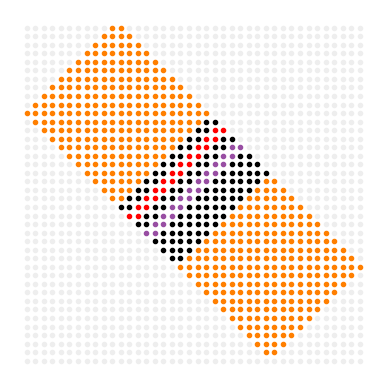

	J(1)/t = 5.173169415955489
484 22


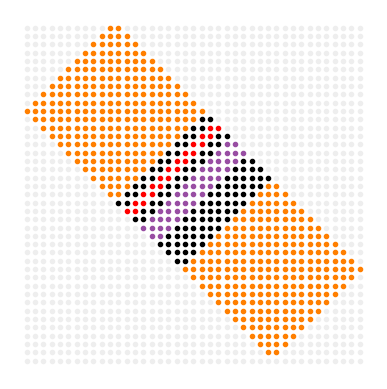

	J(2)/t = 4.575000840353328
484 22


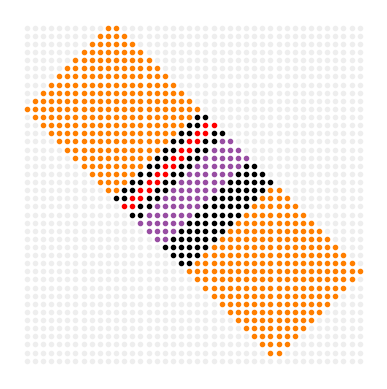

	J(3)/t = 4.107233401628662
484 22


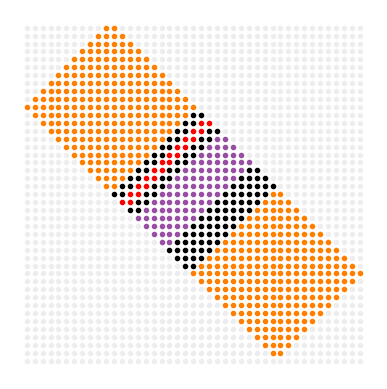

	J(4)/t = 3.7204695989994487
484 22


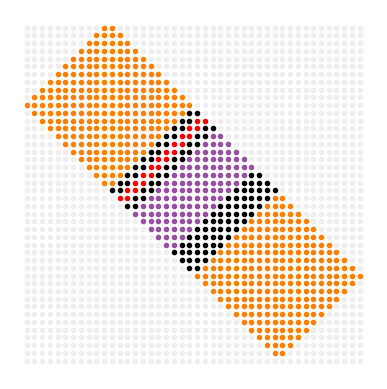

	J(5)/t = 3.3864609813244075
484 22


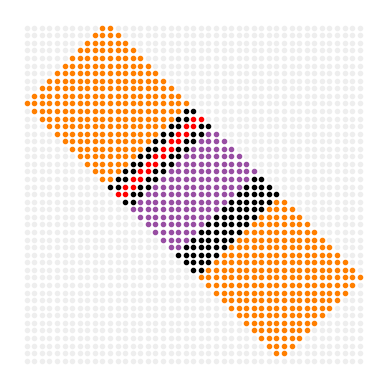

	J(6)/t = 3.133041757758259
484 22


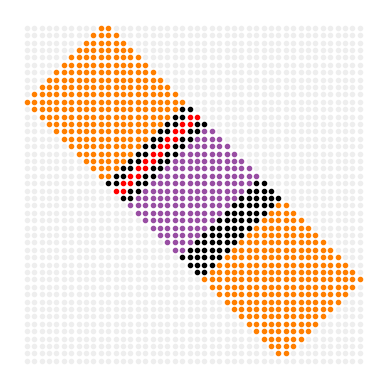

	J(7)/t = 2.9441029678835178
484 22


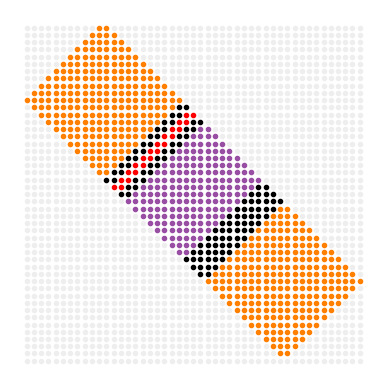

	J(8)/t = 2.7699072532616014
484 22


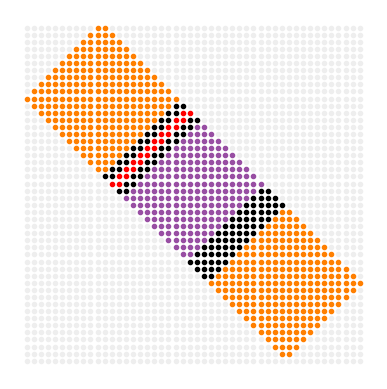

	J(9)/t = 2.592296683156653
484 22


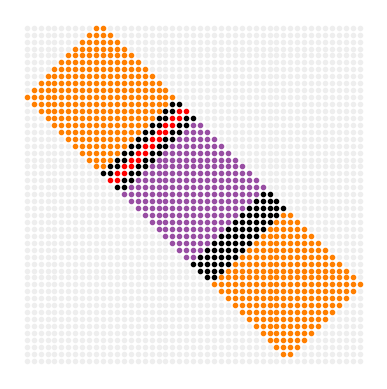

	J(10)/t = 2.4298548178612593
484 22


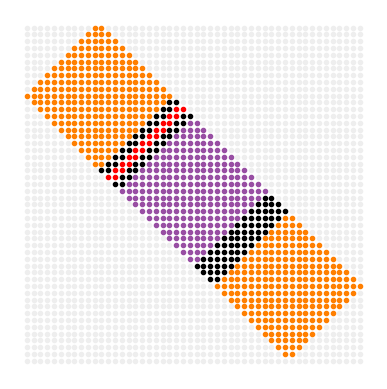



























100%|██████████| 11/11 [07:44<00:00, 42.18s/it]


	J(11)/t = 2.284808362238075
[[1.4142135623730951, 2.8284271247461903, 4.242640687119286, 5.656854249492381, 7.0710678118654755, 8.485281374238571, 9.899494936611665, 11.313708498984761, 12.727922061357857, 14.142135623730951, 15.556349186104047]] [[5.173169415955489, 4.575000840353328, 4.107233401628662, 3.7204695989994487, 3.3864609813244075, 3.133041757758259, 2.9441029678835178, 2.7699072532616014, 2.592296683156653, 2.4298548178612593, 2.284808362238075]]
0.1


484 22


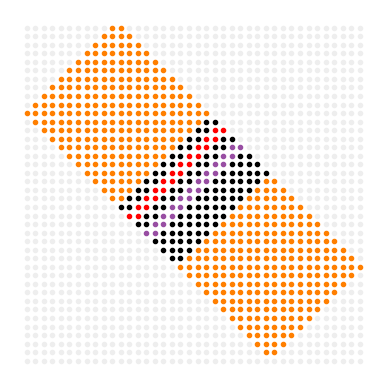

	J(1)/t = 5.148037374894048
484 22


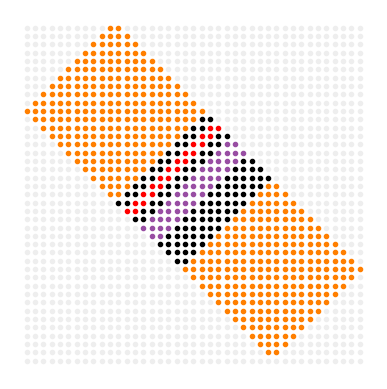

	J(2)/t = 4.180426056321903
484 22


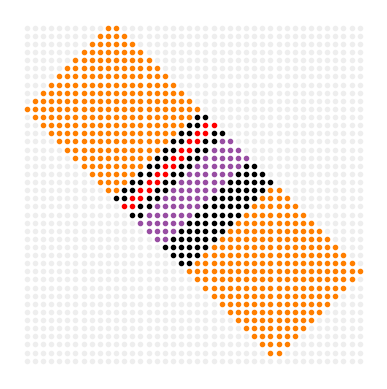












 18%|█▊        | 2/11 [01:26<06:27, 43.04s/it]


KeyboardInterrupt: 

In [23]:
t = 1.0
Δ0 = -t
μ = -t/2
δφ = π/2

L_SC = 11 
L_NM = 3
L_IL = 10
L_Y = 11
L_Z = 1

DIAG = True

LL = []
JJ = []

from tqdm import trange, tqdm

# fig, ax = plt.subplots()
ms = [0.0, 0.10, 0.25, 0.50, 1.00, 1.50, 2.00]
for m in ms:
    print(m)
    Ls = []
    Js = []

    for L_IL in trange(1, 12):
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        lattice = create()
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                if inside(i):
                    H[i, i] = -μ * σ0
                    if SC1(i):
                        Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                    if SC2(i):
                        Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

            for i, j in lattice.bonds(axis=0):
                if inside(i) and inside(j):
                    if IL(i) and IL(j):
                        H[i, j] = -t * σ0 - m * σ3
                    else:
                        H[i, j] = -t * σ0

            for i, j in lattice.bonds(axis=1):
                if inside(i) and inside(j):
                    if IL(i) and IL(j):
                        H[i, j] = -t * σ0 + m * σ3
                    else:
                        H[i, j] = -t * σ0


        Js.append(np.abs(current(system, 1000)))
        Ls.append(L_IL * np.sqrt(2))
        print(f"\tJ({L_IL})/t = {Js[-1]}")
    
    # ax.plot
    LL.append(Ls)
    JJ.append(Js)

    print(LL, JJ)

    # system = Hamiltonian(lattice)
    # with system as (H, Δ, V):
    #     for i in lattice.sites():
    #         if inside(i):
    #             if IL(i):
    #                 H[i, i] = -μ * σ0 - m * σ3
    #             else:
    #                 H[i, i] = -μ * σ0

    #             if SC1(i):
    #                 Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
    #             if SC2(i):
    #                 Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

    #     for i, j in lattice.bonds(axis=0):
    #         if inside(i) and inside(j):
    #             H[i, j] = -t * σ0

    #     for i, j in lattice.bonds(axis=1):
    #         if inside(i) and inside(j):
    #             H[i, j] = -t * σ0

    # Jf.append(current(system, 600))


# plt.plot(Ls, Js, 'r', Ls, Jf, 'b')
# plt.plot(Ls, Js, 'r')
# # plt.ylim([-0.3, +0.3])
# plt.yscale('log')
# plt.xlabel("Interlayer length $L_{IL}/a$")
# plt.ylabel("Supercurrent $I/t$")
# plt.legend(ms)
# plt.show()

# LL.append(Ls)
# JJ.append(Js)

# plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
# plt.xlabel("Interlayer length $L_{IL}/a$")
# plt.ylabel("Supercurrent $I/t$")
# plt.show()

In [17]:
print(LL, JJ)

[] []


  0%|          | 0/14 [00:00<?, ?it/s]

512 16


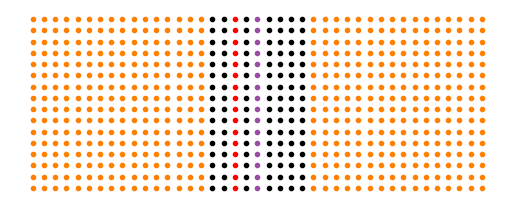

  7%|▋         | 1/14 [00:17<03:50, 17.75s/it]

	J/t = 3.298755317846093
512 16


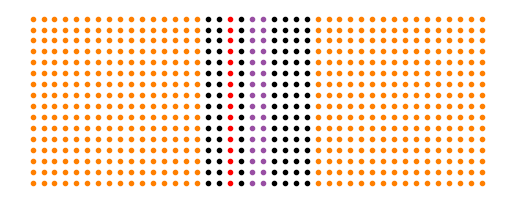

 14%|█▍        | 2/14 [00:36<03:42, 18.57s/it]

	J/t = 1.9482016480686162
512 16


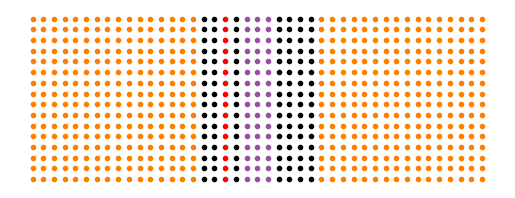

 21%|██▏       | 3/14 [00:56<03:29, 19.06s/it]

	J/t = 1.1371576487497703
512 16


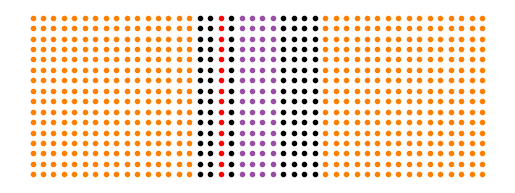

 29%|██▊       | 4/14 [01:17<03:16, 19.62s/it]

	J/t = 0.5257382876765029
512 16


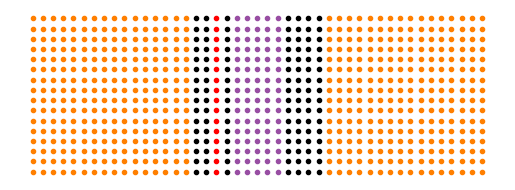

 36%|███▌      | 5/14 [01:38<03:03, 20.44s/it]

	J/t = 0.13867889611290896
512 16


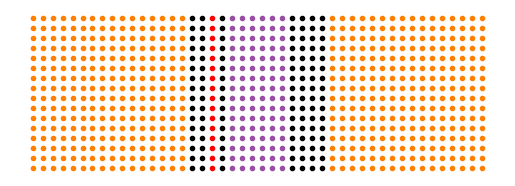

 43%|████▎     | 6/14 [02:01<02:48, 21.04s/it]

	J/t = -0.04551573270834404
512 16


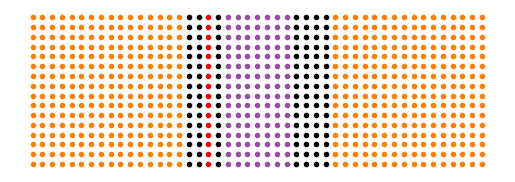

 50%|█████     | 7/14 [02:24<02:32, 21.75s/it]

	J/t = -0.007370089985257223
512 16


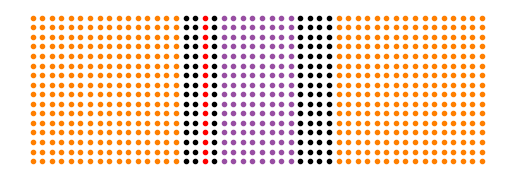

 57%|█████▋    | 8/14 [02:48<02:15, 22.59s/it]

	J/t = -0.0878522377365088
512 16


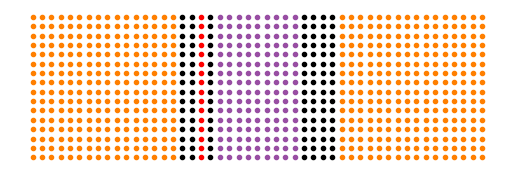

 64%|██████▍   | 9/14 [03:13<01:56, 23.40s/it]

	J/t = -0.049308467411020615
512 16


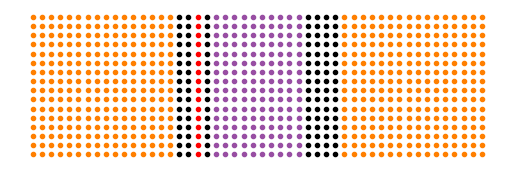

 71%|███████▏  | 10/14 [03:39<01:36, 24.23s/it]

	J/t = -0.04927877514746151
512 16


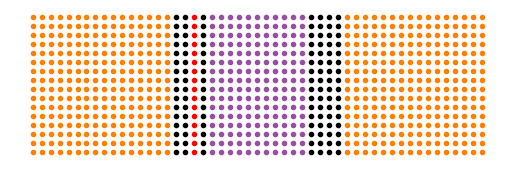

 79%|███████▊  | 11/14 [04:07<01:15, 25.17s/it]

	J/t = 0.003757801584047412
512 16


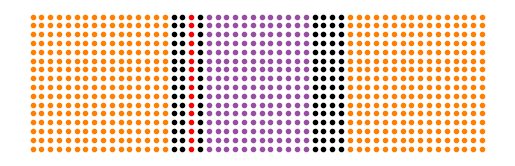

 86%|████████▌ | 12/14 [04:35<00:52, 26.07s/it]

	J/t = 0.00883885249409256
512 16


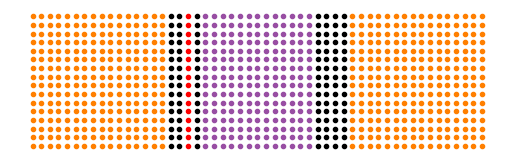

 93%|█████████▎| 13/14 [05:04<00:26, 26.91s/it]

	J/t = 0.051631356569256784
512 16


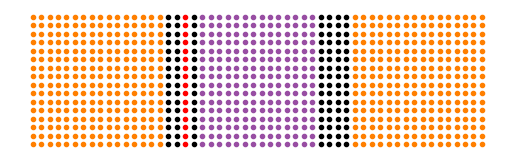

100%|██████████| 14/14 [05:34<00:00, 23.91s/it]

	J/t = 0.05896963076056161


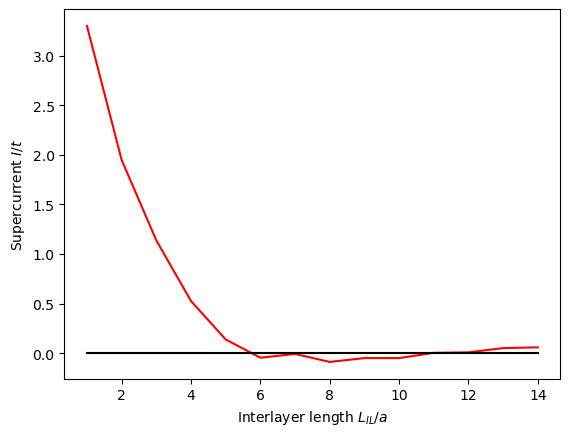

In [27]:
t = 1.0
Δ0 = -t
μ = -t/2
m = 0.25 * t
δφ = π/2

L_SC = int(11 * 1.5) 
L_NM = int(3 * 1.5)
L_IL = 10
L_Y = int(11 * 1.5)
L_Z = 1

DIAG = False

LL = []
JJ = []

Ls = []
Js = []
Jf = []

for L_IL in trange(1, 15):
    L_X = 2 * L_SC + 2 * L_NM + L_IL
    lattice = create()
    system = Hamiltonian(lattice)

    with system as (H, Δ, V):
        for i in lattice.sites():
            if inside(i):
                H[i, i] = -μ * σ0
                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

        for i, j in lattice.bonds(axis=0):
            if inside(i) and inside(j):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 - m * σ3
                else:
                    H[i, j] = -t * σ0

        for i, j in lattice.bonds(axis=1):
            if inside(i) and inside(j):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 + m * σ3
                else:
                    H[i, j] = -t * σ0


    Js.append(current(system, 600))
    Ls.append(L_IL)

    # system = Hamiltonian(lattice)
    # with system as (H, Δ, V):
    #     for i in lattice.sites():
    #         if inside(i):
    #             if IL(i):
    #                 H[i, i] = -μ * σ0 - 3 * m * σ3
    #             else:
    #                 H[i, i] = -μ * σ0

    #             if SC1(i):
    #                 Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
    #             if SC2(i):
    #                 Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

    #     for i, j in lattice.bonds(axis=0):
    #         if inside(i) and inside(j):
    #             H[i, j] = -t * σ0

    #     for i, j in lattice.bonds(axis=1):
    #         if inside(i) and inside(j):
    #             H[i, j] = -t * σ0

    # Jf.append(current(system, 600))

    print(f"\tJ/t = {Js[-1]}")

plt.plot(Ls, Js, 'r', Ls, [0 for L in Ls], 'k')
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

# LL.append(Ls)
# JJ.append(Js)

# plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
# plt.xlabel("Interlayer length $L_{IL}/a$")
# plt.ylabel("Supercurrent $I/t$")
# plt.show()

## New simulations
It appears that altermagnets are sensitive to the choice of `m`. Lets experiment with that then.


m/t = 0.5


  0%|          | 0/18 [00:00<?, ?it/s]

242 11


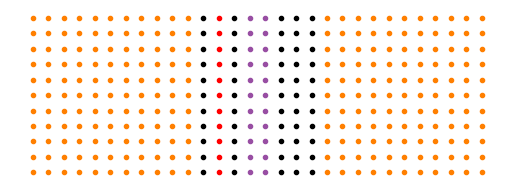

  6%|▌         | 1/18 [00:16<04:32, 16.02s/it]

	J(2)/t = 0.3591276285981655
242 11


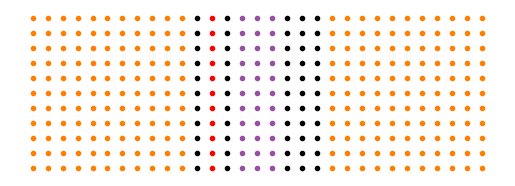

 11%|█         | 2/18 [00:32<04:23, 16.46s/it]

	J(3)/t = 0.16150070068116296
242 11


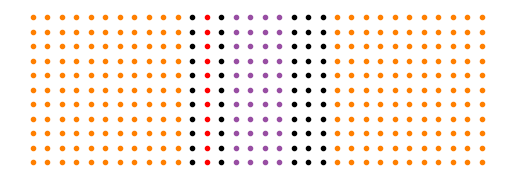

 17%|█▋        | 3/18 [00:50<04:14, 16.98s/it]

	J(4)/t = 0.21391752700246375
242 11


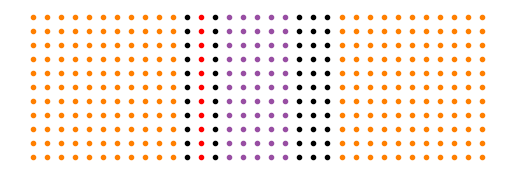

 22%|██▏       | 4/18 [01:09<04:07, 17.70s/it]

	J(5)/t = 0.11014856820000148
242 11


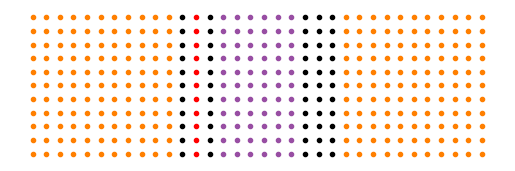

 28%|██▊       | 5/18 [01:29<04:00, 18.48s/it]

	J(6)/t = -0.12951228153544564
242 11


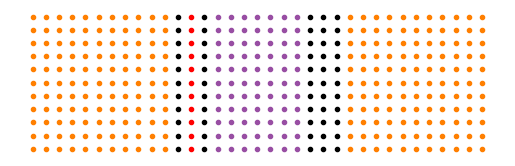

 33%|███▎      | 6/18 [01:50<03:52, 19.36s/it]

	J(7)/t = -0.3428269083211221
242 11


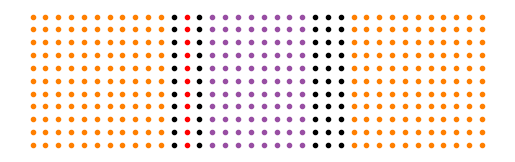

 39%|███▉      | 7/18 [02:12<03:42, 20.25s/it]

	J(8)/t = -0.4053313360329551
242 11


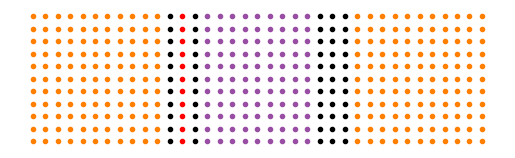

 44%|████▍     | 8/18 [02:35<03:31, 21.18s/it]

	J(9)/t = -0.3432847517614023
242 11


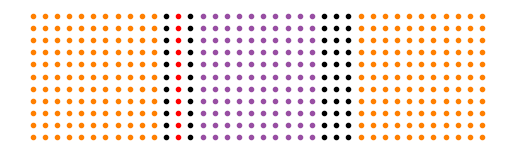

 50%|█████     | 9/18 [02:59<03:19, 22.16s/it]

	J(10)/t = -0.3064682574236557
242 11


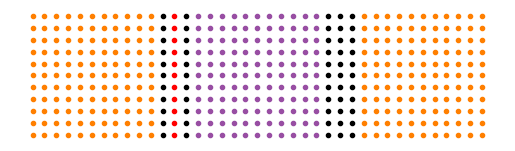

 56%|█████▌    | 10/18 [03:25<03:06, 23.29s/it]

	J(11)/t = -0.2946503138864578
242 11


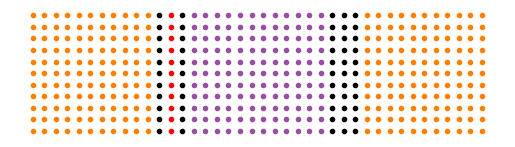

 61%|██████    | 11/18 [03:52<02:51, 24.46s/it]

	J(12)/t = -0.2292906471022677
242 11


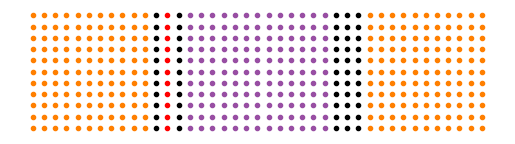

 67%|██████▋   | 12/18 [04:20<02:33, 25.61s/it]

	J(13)/t = -0.1220235504152326
242 11


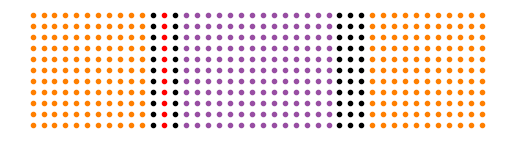

 72%|███████▏  | 13/18 [04:50<02:14, 26.82s/it]

	J(14)/t = 0.011163962798728923
242 11


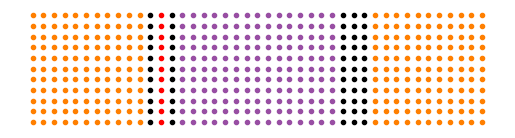

 78%|███████▊  | 14/18 [05:21<01:51, 27.97s/it]

	J(15)/t = 0.12457902260906706
242 11


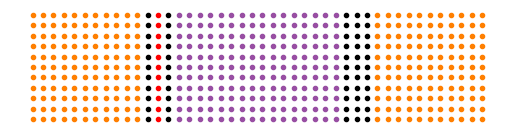

 83%|████████▎ | 15/18 [05:53<01:27, 29.17s/it]

	J(16)/t = 0.1778357087414352
242 11


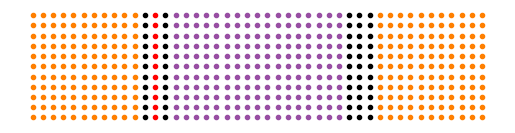

 89%|████████▉ | 16/18 [06:27<01:01, 30.62s/it]

	J(17)/t = 0.19756346197627878
242 11


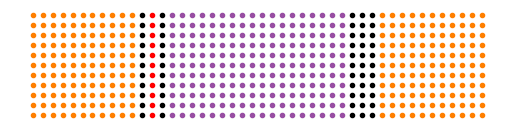

 94%|█████████▍| 17/18 [07:01<00:31, 31.92s/it]

	J(18)/t = 0.21412227957778457
242 11


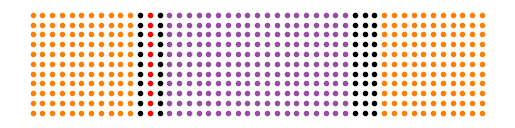

100%|██████████| 18/18 [07:38<00:00, 25.46s/it]


	J(19)/t = 0.20058302577729292
[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]] [[0.3591276285981655, 0.16150070068116296, 0.21391752700246375, 0.11014856820000148, -0.12951228153544564, -0.3428269083211221, -0.4053313360329551, -0.3432847517614023, -0.3064682574236557, -0.2946503138864578, -0.2292906471022677, -0.1220235504152326, 0.011163962798728923, 0.12457902260906706, 0.1778357087414352, 0.19756346197627878, 0.21412227957778457, 0.20058302577729292]]
m/t = 1.5


  0%|          | 0/18 [00:00<?, ?it/s]

242 11


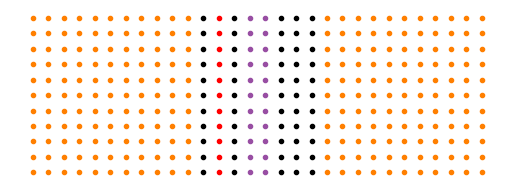

  6%|▌         | 1/18 [00:15<04:31, 15.96s/it]

	J(2)/t = -0.03916652862053359
242 11


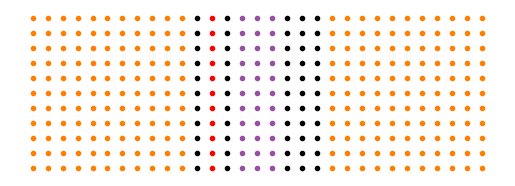

 11%|█         | 2/18 [00:32<04:22, 16.39s/it]

	J(3)/t = 0.06083230216749316
242 11


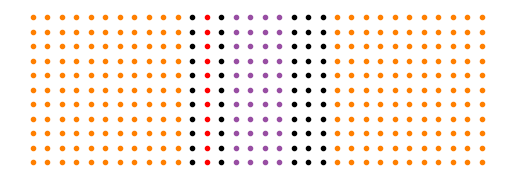

 17%|█▋        | 3/18 [00:50<04:16, 17.11s/it]

	J(4)/t = -0.03517816188542623
242 11


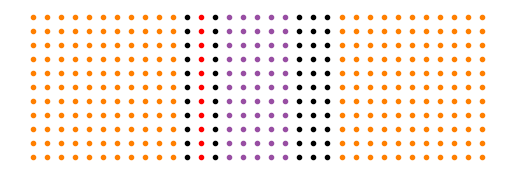

 22%|██▏       | 4/18 [01:09<04:09, 17.84s/it]

	J(5)/t = 0.21589944905653158
242 11


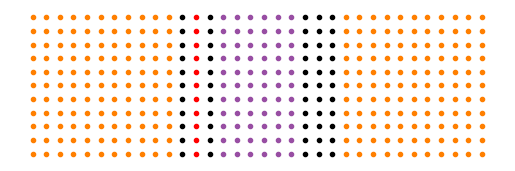

 28%|██▊       | 5/18 [01:29<04:01, 18.56s/it]

	J(6)/t = -0.050143155808479355
242 11


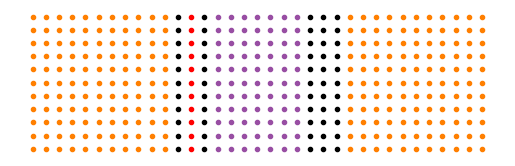

 33%|███▎      | 6/18 [01:50<03:53, 19.48s/it]

	J(7)/t = -0.11280660934245174
242 11


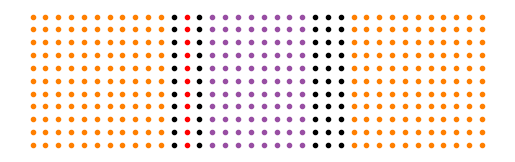

 39%|███▉      | 7/18 [02:12<03:43, 20.28s/it]

	J(8)/t = 0.32908950502440004
242 11


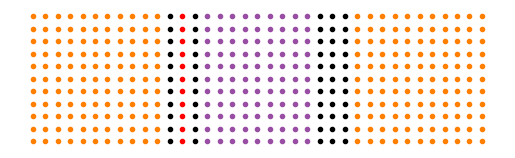

 44%|████▍     | 8/18 [02:35<03:32, 21.26s/it]

	J(9)/t = -0.41156697272911313
242 11


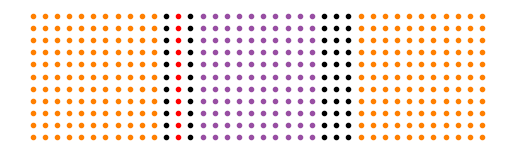

 50%|█████     | 9/18 [03:00<03:20, 22.24s/it]

	J(10)/t = 0.29417919914089247
242 11


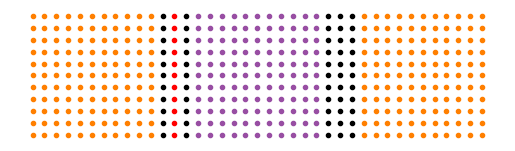

 56%|█████▌    | 10/18 [03:26<03:07, 23.46s/it]

	J(11)/t = -0.07662666090263207
242 11


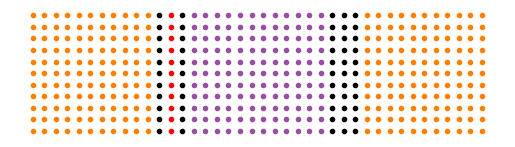

 61%|██████    | 11/18 [03:53<02:51, 24.46s/it]

	J(12)/t = -0.09471014694699253
242 11


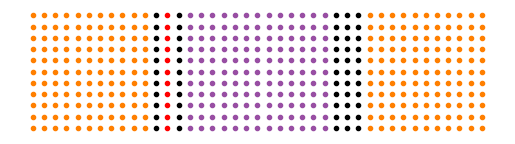

 67%|██████▋   | 12/18 [04:21<02:33, 25.56s/it]

	J(13)/t = 0.08055391109338846
242 11


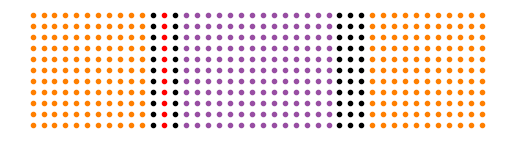

 72%|███████▏  | 13/18 [04:50<02:13, 26.75s/it]

	J(14)/t = -0.05864118500629923
242 11


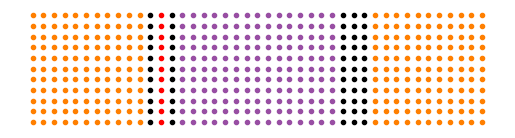

 78%|███████▊  | 14/18 [05:21<01:51, 27.99s/it]

	J(15)/t = 0.04010402243056995
242 11


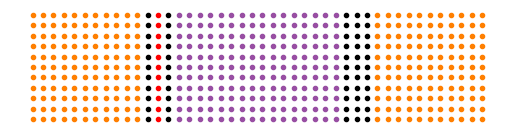

 83%|████████▎ | 15/18 [05:53<01:27, 29.20s/it]

	J(16)/t = -0.12768458871059324
242 11


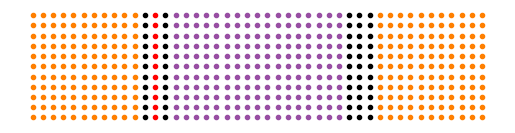

 89%|████████▉ | 16/18 [06:27<01:01, 30.54s/it]

	J(17)/t = 0.1917540889401292
242 11


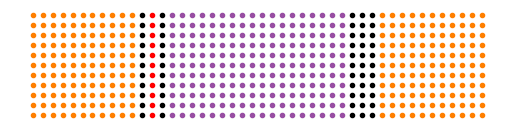

 94%|█████████▍| 17/18 [07:02<00:31, 31.86s/it]

	J(18)/t = -0.20013244070763037
242 11


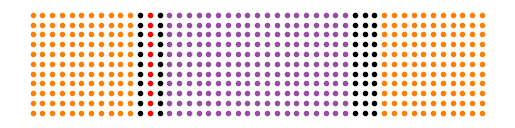

100%|██████████| 18/18 [07:38<00:00, 25.48s/it]

	J(19)/t = 0.07942060103681343
[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]] [[0.3591276285981655, 0.16150070068116296, 0.21391752700246375, 0.11014856820000148, -0.12951228153544564, -0.3428269083211221, -0.4053313360329551, -0.3432847517614023, -0.3064682574236557, -0.2946503138864578, -0.2292906471022677, -0.1220235504152326, 0.011163962798728923, 0.12457902260906706, 0.1778357087414352, 0.19756346197627878, 0.21412227957778457, 0.20058302577729292], [-0.03916652862053359, 0.06083230216749316, -0.03517816188542623, 0.21589944905653158, -0.050143155808479355, -0.11280660934245174, 0.32908950502440004, -0.41156697272911313, 0.29417919914089247, -0.07662666090263207, -0.09471014694699253, 0.08055391109338846, -0.05864118500629923, 0.04010402243056995, -0.12768458871059324, 0.1917540889401292, -0.20013244070763037, 0.07942060103681343]]


In [31]:
t = 1.0
Δ0 = 0.3*t
μ = -0.5*t
δφ = π/2

L_SC = 11 
L_NM = 3
L_Y = 11
L_Z = 1

DIAG = False

LL = []
JJ = []

from tqdm import trange, tqdm

ms = [0.5, 1.5]
for m in ms:
    print(f"m/t = {m}")
    Ls = []
    Js = []

    for L_IL in trange(2, 20):
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        lattice = create()
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                if inside(i):
                    H[i, i] = -μ * σ0
                    if SC1(i):
                        Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                    if SC2(i):
                        Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

            for i, j in lattice.bonds(axis=0):
                if inside(i) and inside(j):
                    if IL(i) and IL(j):
                        H[i, j] = -t * σ0 - m * σ3
                    else:
                        H[i, j] = -t * σ0

            for i, j in lattice.bonds(axis=1):
                if inside(i) and inside(j):
                    if IL(i) and IL(j):
                        H[i, j] = -t * σ0 + m * σ3
                    else:
                        H[i, j] = -t * σ0


        Js.append(current(system, 2000))
        Ls.append(L_IL)
        print(f"\tJ({L_IL})/t = {Js[-1]}")
    
    LL.append(Ls)
    JJ.append(Js)

    print(LL, JJ)

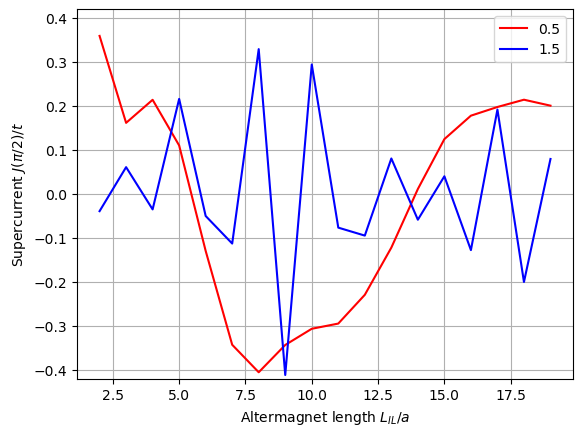

In [36]:
fig, ax = plt.subplots()
ax.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
ax.legend(ms)
ax.set_xlabel(r"Altermagnet length $L_{IL}/a$")
ax.set_ylabel(r"Supercurrent $J(π/2)/t$")
ax.set_ylim([-0.42, 0.42])
ax.grid()
plt.show()

Let's now go back to diagonal cuts.

In [ ]:
t = 1.0
Δ0 = 0.3*t
μ = -0.5*t
δφ = π/2

L_SC = 8 
L_NM = 3
L_Y = 8
L_Z = 1

DIAG = True

LL2 = []
JJ2 = []

from tqdm import trange, tqdm

ms = [0.5, 1.5]
for m in ms:
    print(f"m/t = {m}")
    Ls = []
    Js = []

    for L_IL in trange(2, 20):
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        lattice = create()
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                if inside(i):
                    H[i, i] = -μ * σ0
                    if SC1(i):
                        Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                    if SC2(i):
                        Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

            for i, j in lattice.bonds(axis=0):
                if inside(i) and inside(j):
                    if IL(i) and IL(j):
                        H[i, j] = -t * σ0 - m * σ3
                    else:
                        H[i, j] = -t * σ0

            for i, j in lattice.bonds(axis=1):
                if inside(i) and inside(j):
                    if IL(i) and IL(j):
                        H[i, j] = -t * σ0 + m * σ3
                    else:
                        H[i, j] = -t * σ0


        Js.append(current(system, 2000))
        Ls.append(L_IL * np.sqrt(2))
        print(f"\tJ({L_IL})/t = {Js[-1]}")
    
    LL2.append(Ls)
    JJ2.append(Js)

    print(LL2, JJ2)

## L-shaped junctions

Idea: What if we make L-shaped junctions of altermagnets with superconductors at the end, and vary the two independently? If we plot this in a 2D plot, do we perhaps get 0-π oscillations only for deviations?